In [236]:
import time
import os
from functools import lru_cache, partial
import json
import json5
import re
import asyncio
from datetime import datetime
from typing import List, Optional, Dict, Any
from pydantic import BaseModel, Field
from typing import TypedDict
from IPython.display import Image
from operator import itemgetter
from sqlglot import exp, parse_one

from langchain_core.messages.tool import ToolCall
from langchain_core.messages import (
    AnyMessage,
    SystemMessage,
    HumanMessage,
    AIMessage,
)

from tqdm.asyncio import tqdm_asyncio

from langchain_openai import ChatOpenAI
from langchain_core.language_models import BaseChatModel
from langchain_community.embeddings import InfinityEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.tools import tool
from langchain_core.runnables import RunnablePassthrough, RunnableLambda, Runnable
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.state import CompiledStateGraph

from dotenv import load_dotenv

load_dotenv()

True

# Setup components

In [2]:
LLM_BASE_URL=os.getenv("LLM_BASE_URL")
LLM_MODEL=os.getenv("LLM_MODEL")
LLM_API_KEY=os.getenv("LLM_API_KEY")

EMBED_BASE_URL=os.getenv("EMBED_BASE_URL")
EMBED_MODEL=os.getenv("EMBED_MODEL")


@lru_cache()
def get_llm_model():
    return ChatOpenAI(
        model=LLM_MODEL,
        base_url=LLM_BASE_URL,
        api_key=LLM_API_KEY,
        temperature=0.7,
        top_p=0.8,
        presence_penalty=1,
        extra_body = {
            'chat_template_kwargs': {'enable_thinking': False},
            "top_k": 20,
            "mip_p": 0,
        },
    )

@lru_cache()
def get_thinking_llm_model():
    return ChatOpenAI(
        model=LLM_MODEL,
        base_url=LLM_BASE_URL,
        api_key=LLM_API_KEY,
        temperature=0.6,
        top_p=0.95,
        presence_penalty=1,
        extra_body = {
            'chat_template_kwargs': {'enable_thinking': True},
            "top_k": 20,
            "mip_p": 0,
        },
    )

@lru_cache()
def get_embedding_model():
    return InfinityEmbeddings(
        model=EMBED_MODEL,
        infinity_api_url=EMBED_BASE_URL,
    )


@lru_cache()
def get_vector_store():
    client = QdrantClient(
        url="http://localhost",
        grpc_port=6334,
        prefer_grpc=True,
    )
    embedding_model = get_embedding_model()
    client.create_collection(
        collection_name="demo",
        vectors_config=VectorParams(
            size=len(embedding_model.embed_query("Hello")), 
            distance=Distance.COSINE
        ),
    )
    return QdrantVectorStore(
        client=client,
        collection_name="demo",
        embedding=embedding_model,
    )


# @lru_cache()
# def get_sqlite_db():
#     return SQLDatabase.from_uri("sqlite:////Users/vinhnguyen/Projects/ext-chatbot/resources/database/batdongsan.db")


# Process data

## Excel

In [2]:
import glob
from src.tools.table import create_sqlite, create_faiss

In [3]:
tables = []
for filepath in glob.glob("/Users/vinhnguyen/Projects/ext-chatbot/resources/processed_data/batdongsan_1/*.json"):
    table_name = ".".join(filepath.split("/")[-1].split(".")[:-1])
    with open(filepath, "r") as f:
        table = json.load(f)
        table["pydantic_schema"]["title"] = table_name
        if len(table["transformed_data"]) > 100:
            tables.append(table)

print([table["pydantic_schema"]["title"] for table in tables])
print(2)

['BĐS Cho thuê 500', 'BĐS Bán 500']
2


In [ ]:
# for table in tables:
#     create_sqlite(
#         schema=table["pydantic_schema"],
#         column_groups=table["column_groups"],
#         data=table["transformed_data"],
#         db_path="/Users/vinhnguyen/Projects/ext-chatbot/resources/database/batdongsan.db",
#     )


for table in tables:
    create_faiss(
        schema=table["pydantic_schema"],
        db_path="/Users/vinhnguyen/Projects/ext-chatbot/resources/database/batdongsan.db",
        faiss_dir="/Users/vinhnguyen/Projects/ext-chatbot/resources/faiss/",
    )


Embedding BĐS Cho thuê 500.Giá/m²/tháng: 100%|██████████| 492/492 [00:02<00:00, 167.45values/s]
Embedding BĐS Cho thuê 500.Ngày có thể chuyển vào: 100%|██████████| 61/61 [00:00<00:00, 119.56values/s]
Embedding BĐS Cho thuê 500.Tình trạng: 100%|██████████| 4/4 [00:00<00:00, 39.47values/s]
Embedding BĐS Cho thuê 500.Cho phép nuôi thú cưng: 100%|██████████| 3/3 [00:00<00:00, 33.10values/s]
Embedding BĐS Cho thuê 500.Bãi đỗ xe: 100%|██████████| 5/5 [00:00<00:00, 48.14values/s]
Embedding BĐS Cho thuê 500.Thời hạn thuê tối thiểu: 100%|██████████| 5/5 [00:00<00:00, 45.76values/s]
Embedding BĐS Cho thuê 500.Tiện ích lân cận: 100%|██████████| 481/481 [00:02<00:00, 169.54values/s]
Embedding BĐS Cho thuê 500.Khoảng cách tới trung tâm: 100%|██████████| 144/144 [00:00<00:00, 153.40values/s]
Embedding BĐS Cho thuê 500.Tiền cọc: 100%|██████████| 474/474 [00:03<00:00, 151.31values/s]
Embedding BĐS Cho thuê 500.Khoảng cách tới trung tâm_đơn vị: 100%|██████████| 1/1 [00:00<00:00, 13.00values/s]
Embeddin

In [38]:
# Request more files from PO to test

# Utils

In [4]:
def extract_fn(text: str) -> tuple[str, str]:
    """Extract function name and arguments from tool call text."""
    fn_name, fn_args = '', ''
    fn_name_s = '"name": "'
    fn_name_e = '", "'
    fn_args_s = '"arguments": '
    
    i = text.find(fn_name_s)
    k = text.find(fn_args_s)
    
    if i > 0:
        _text = text[i + len(fn_name_s):]
        j = _text.find(fn_name_e)
        if j > -1:
            fn_name = _text[:j]
    
    if k > 0:
        fn_args = text[k + len(fn_args_s):]
    
    fn_args = fn_args.strip()
    if len(fn_args) > 2:
        fn_args = fn_args[:-1]
    else:
        fn_args = ''
    
    return fn_name, fn_args


def postprocess_ai_message(
    ai_message: AIMessage,
) -> List[AIMessage]:
    """
    Convert AIMessage with <tool_call> tags to proper LangChain message with tool calls and leave it in a list to integrate with MessagesState.
    Assumes all content is text (no multimodal).
    """
    tool_id = 1
    
    content: str = ai_message.content if isinstance(ai_message.content, str) else str(ai_message.content)
    
    # Handle <think> tags - skip tool call parsing inside thinking
    if '<think>' in content:
        if '</think>' not in content:
            # Incomplete thinking, add as regular message
            return [ai_message]
        
        # Split thinking from rest of content
        parts = content.split('</think>')
        content = parts[-1]
        
    
    # Find tool calls in content
    if '<tool_call>' not in content:
        # No tool calls, add as regular message
        return [AIMessage(content=content.strip())]
    
    # Split content by tool calls
    tool_call_list = content.split('<tool_call>')
    pre_text = tool_call_list[0].strip()
    tool_calls: List[ToolCall] = []
    
    # Process each tool call
    for txt in tool_call_list[1:]:
        if not txt.strip():
            continue
        
        # Handle incomplete tool calls (no closing tag)
        if '</tool_call>' not in txt:
            fn_name, fn_args = extract_fn(txt)
            if fn_name:
                tool_calls.append(
                    ToolCall(
                        name=fn_name,
                        args=json.loads(fn_args) if fn_args else {},
                        id=str(tool_id),
                    )
                )
                tool_id += 1
                # new_messages.append(AIMessage(content='', tool_calls=tool_calls))
            continue
        
        # Handle complete tool calls
        one_tool_call_txt = txt.split('</tool_call>')[0].strip()
        
        try:
            # Try to parse as JSON
            fn = json5.loads(one_tool_call_txt)
            if 'name' in fn and 'arguments' in fn:
                tool_calls.append(
                    ToolCall(
                        name=fn['name'],
                        args=fn['arguments'],
                        id=str(tool_id),
                    )
                )
                tool_id += 1
                # new_messages.append(AIMessage(content='', tool_calls=tool_calls))
        except Exception:
            # Fallback to manual extraction
            fn_name, fn_args = extract_fn(one_tool_call_txt)
            if fn_name:
                tool_calls.append(
                    ToolCall(
                        name=fn_name,
                        args=json.loads(fn_args) if fn_args else {},
                        id=str(tool_id),
                    )
                )
                tool_id += 1
                # new_messages.append(AIMessage(content='', tool_calls=tool_calls))
        
    if tool_calls:
        return [AIMessage(content=pre_text, tool_calls=tool_calls)]
    elif pre_text:
        return [AIMessage(content=pre_text)]
    else:
        return [AIMessage(content=content)]

In [17]:
def get_today_date_en() -> str:
    """Get today's date formatted for system message."""
    today = datetime.today()
    day_names = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    day_of_week = day_names[today.weekday()]
    month_name_full = today.strftime("%B")
    if today.day % 10 == 1 and today.day != 11:
        day_suffix = "st"
    elif today.day % 10 == 2 and today.day != 12:
        day_suffix = "nd"
    elif today.day % 10 == 3 and today.day != 13:
        day_suffix = "rd"
    else:
        day_suffix = "th"
    return f"{day_of_week}, {month_name_full} {today.day}{day_suffix}, {today.year}"


def get_today_date_vi() -> str:
    today = datetime.today()
    day_names = [
        "Thứ hai",
        "Thứ ba",
        "Thứ tư",
        "Thứ năm",
        "Thứ sáu",
        "Thứ bảy",
        "Chủ nhật",
    ]
    day_of_week = day_names[today.weekday()]
    return f"{day_of_week}, ngày {today.day}, tháng {today.month}, năm {today.year}"


def preprocess_messages(
    state: BaseModel,
    system_prompt: str,
) -> List[AnyMessage]:
    """
    Convert LangChain messages with tool calls to plaintext format with <tool_call> tags.
    Converts ToolMessages to <tool_response> tags.
    Assumes all content is text (no multimodal).
    """
    if "messages" not in state:
        raise ValueError("messages not found in state")
    messages: List[AnyMessage] = state["messages"]
    new_messages = []

    if messages[0].type == "system":
        new_messages.append(messages[0])
    else:
        date_info = "Hôm nay là {date}.\n".format(date=get_today_date_vi())
        new_messages.append(SystemMessage(
            content=date_info + system_prompt
        ))
        messages = [SystemMessage(content=date_info + system_prompt)] + messages

    for msg in messages[1:]:
        # Pass through human messages as-is
        if msg.type == "human":
            new_messages.append(msg)
            continue
        # Handle AI messages with tool calls
        elif msg.type == "ai":
            content = msg.content if isinstance(msg.content, str) else str(msg.content)
            
            # Convert tool calls to plaintext format
            if msg.tool_calls:
                for tool_call in msg.tool_calls:
                    fc = {
                        'name': tool_call['name'],
                        'arguments': tool_call['args']
                    }
                    fc_str = json.dumps(fc, ensure_ascii=False)
                    tool_call_text = f'<tool_call>\n{fc_str}\n</tool_call>'
                    
                    # Append to content
                    if content:
                        content += '\n' + tool_call_text
                    else:
                        content = tool_call_text
            
            # Merge consecutive AI messages
            if new_messages and new_messages[-1].type == "ai":
                prev_content = new_messages[-1].content
                if prev_content and not prev_content.endswith('\n'):
                    prev_content += '\n'
                new_messages[-1] = AIMessage(content=prev_content + content)
            else:
                new_messages.append(AIMessage(content=content))
            continue
        # Handle tool messages - convert to <tool_response> wrapped in HumanMessage
        elif msg.type == "tool":
            content = msg.content if isinstance(msg.content, str) else str(msg.content)
            response_text = f'<tool_response>\n{content}\n</tool_response>'
            if new_messages and new_messages[-1].type == "human":
                prev_content = new_messages[-1].content
                prev_content += '\n' + response_text
                new_messages[-1] = HumanMessage(content=prev_content)
            else:
                new_messages.append(HumanMessage(content=response_text))
            continue
    
    return new_messages


# SQLite Database

In [34]:
import json
import re
import os
import asyncio
from typing import Any, Dict, Iterable, List, Literal, Sequence, Tuple, Union, Optional

import faiss
import numpy as np
from sqlalchemy import (
    MetaData,
    Table,
    Column,
    create_engine,
    inspect,
    text,
)
from sqlalchemy.engine import Engine, Result
from sqlalchemy.exc import ProgrammingError, SQLAlchemyError
from sqlalchemy.types import NullType

from langchain_core.embeddings import Embeddings

In [226]:
def truncate_word(content: Any, *, length: int, suffix: str = "...") -> str:
    """Truncate a string to a certain number of words, based on the max string length."""
    if not isinstance(content, str) or length <= 0:
        return content
    if len(content) <= length:
        return content
    return content[: length - len(suffix)].rsplit(" ", 1)[0] + suffix


def _safe_filename(name: str) -> str:
    """Make a reasonably safe filename from table/column names."""
    if not isinstance(name, str):
        name = str(name)
    # Keep unicode but remove path separators and problematic chars
    name = name.replace(os.sep, "_").replace("\x00", "_")
    name = re.sub(r"[<>:\"/\\|?*\n\r\t]+", "_", name).strip()
    return name or "unnamed"


class SQLiteDatabase:
    """SQLAlchemy wrapper around a SQLite database with column comments support."""

    def _render_type(self, col_type: Any, *, default: str = "TEXT") -> str:
        """Render SQLAlchemy type using this engine's dialect when possible."""
        if col_type is None or isinstance(col_type, NullType):
            return default
        try:
            compiled = col_type.compile(dialect=self._engine.dialect)
            if isinstance(compiled, str) and compiled.strip():
                return compiled.strip()
        except Exception:
            pass
        try:
            rendered = str(col_type)
            return rendered.strip() if rendered.strip() else default
        except Exception:
            return default


    def __init__(
        self,
        engine: Engine,
        ignore_tables: Optional[List[str]] = None,
        include_tables: Optional[List[str]] = None,
        indexes_in_table_info: bool = False,
        max_string_length: int = 200,
        lazy_table_reflection: bool = False,
        faiss_dir: Optional[str] = None,
        embeddings: Optional[Embeddings] = None,
        concurrency_limit: int = 10,
    ):
        """
        Create SQLite database wrapper.
        
        Args:
            engine: SQLAlchemy engine connected to SQLite database
            ignore_tables: List of table names to ignore
            include_tables: List of table names to include (mutually exclusive with ignore_tables)
            indexes_in_table_info: Whether to include index information in table info
            max_string_length: Maximum string length for truncating values
            lazy_table_reflection: Whether to lazily reflect tables
            faiss_dir: Root directory that stores FAISS artifacts (see create_faiss)
            embeddings: Optional pre-initialized InfinityEmbeddings instance to reuse
            embed_model: Model name for InfinityEmbeddings (used when embeddings is None)
            infinity_api_url: Infinity API endpoint (used when embeddings is None)
        """
        self._engine = engine
        if self._engine.dialect.name != "sqlite":
            raise ValueError("SQLiteDatabase only supports SQLite databases")
        
        if include_tables and ignore_tables:
            raise ValueError("Cannot specify both include_tables and ignore_tables")

        self._inspector = inspect(self._engine)
        self._all_tables = set(self._inspector.get_table_names())

        self._include_tables = set(include_tables) if include_tables else set()
        if self._include_tables:
            missing_tables = self._include_tables - self._all_tables
            if missing_tables:
                raise ValueError(f"include_tables {missing_tables} not found in database")
        
        self._ignore_tables = set(ignore_tables) if ignore_tables else set()
        if self._ignore_tables:
            missing_tables = self._ignore_tables - self._all_tables
            if missing_tables:
                raise ValueError(f"ignore_tables {missing_tables} not found in database")
        
        usable_tables = self.get_usable_table_names()
        self._usable_tables = set(usable_tables) if usable_tables else self._all_tables

        self._indexes_in_table_info = indexes_in_table_info
        self._max_string_length = max_string_length
        self._faiss_dir = faiss_dir
        self._faiss_indexes: Dict[str, Dict[str, Dict[str, Any]]] = {}
        self._faiss_embeddings = embeddings
        self._semaphore = asyncio.Semaphore(concurrency_limit)

        self._metadata = MetaData()
        if not lazy_table_reflection:
            self._metadata.reflect(
                bind=self._engine,
                only=list(self._usable_tables),
            )

        if self._faiss_dir:
            self._load_faiss_indexes()


    @classmethod
    def from_uri(
        cls,
        database_uri: str,
        engine_args: Optional[dict] = None,
        **kwargs: Any,
    ) -> "SQLiteDatabase":
        """Construct a SQLiteDatabase from URI."""
        _engine_args = engine_args or {}
        return cls(create_engine(database_uri, **_engine_args), **kwargs)


    @property
    def dialect(self) -> str:
        """Return string representation of dialect to use."""
        return "SQLite"


    def get_usable_table_names(self) -> Iterable[str]:
        """Get names of tables available."""
        if self._include_tables:
            base = set(self._include_tables)
        else:
            base = self._all_tables - self._ignore_tables

        # filter out metadata tables (companion EAV tables)
        base = {tbl for tbl in base if not tbl.endswith("__metadata")}
        return sorted(base)


    def get_column_datatype(
        self,
        table_name: str,
        column_name: str,
        default: str = "TEXT",
    ) -> str:
        """
        Return SQL datatype for a column in a table.

        Notes:
        - Uses SQLAlchemy inspector, so it does not require table reflection.
        - Returns `default` when the table/column is not found or the type is unknown.
        """
        all_table_names = set(self.get_usable_table_names())
        if table_name not in all_table_names:
            raise ValueError(
                f"Table '{table_name}' not found in database. Available tables: {sorted(all_table_names)}"
            )

        try:
            cols = self._inspector.get_columns(table_name)
        except SQLAlchemyError:
            return default

        for col in cols:
            if col.get("name") != column_name:
                continue
            col_type = col.get("type")
            return self._render_type(col_type, default=default)

        return default


    def get_column_names(self, table_name: str) -> List[str] | None:
        """
        Return the names of columns in a table.
        """
        all_table_names = list(self.get_usable_table_names())
        if table_name not in all_table_names:
            raise ValueError(f"Table '{table_name}' not found in database. Available tables: {all_table_names}")
        try:
            column_names = []
            for col in self._inspector.get_columns(table_name):
                col_name = col.get("name")
                if isinstance(col_name, str):
                    column_names.append(col_name)
            return column_names
        except SQLAlchemyError:
            return None


    def get_table_info(
        self,
        table_name: str,
        get_col_comments: bool = False,
        allowed_col_names: Optional[List[str]] = None,
        sample_count: Optional[int] = None,
        column_sample_values: Optional[Dict[str, List[str]]] = None,
    ) -> str:
        """
        Get information about a specified table.

        Args:
            table_name: Name of the table to get info for
            get_col_comments: Whether to include column comments in the output
            allowed_col_names: If provided, only include these columns in the output.
                              If None, include all columns.
            sample_count: Number of distinct example values to include for each column.
                          If None, no example values are included (unless provided via
                          column_sample_values).
            column_sample_values: Optional mapping from column name to a list of
                          precomputed example values. For columns present in this
                          mapping, these values are used directly. For remaining
                          columns, example values are fetched via `_get_sample_values`
                          when sample_count is provided.

        Returns:
            String containing table schema (CREATE TABLE statement) and optionally
            column comments and sample rows.
        """
        all_table_names = list(self.get_usable_table_names())
        if table_name not in all_table_names:
            raise ValueError(f"Table '{table_name}' not found in database. Available tables: {all_table_names}")

        # Ensure table is reflected
        metadata_table_names = [tbl.name for tbl in self._metadata.sorted_tables]
        if table_name not in metadata_table_names:
            self._metadata.reflect(
                bind=self._engine,
                only=[table_name],
            )

        # Find the table object
        table = None
        for tbl in self._metadata.sorted_tables:
            if tbl.name == table_name:
                table = tbl
                break

        if table is None:
            raise ValueError(f"Table '{table_name}' could not be reflected")

        # Remove NullType columns
        try:
            for _, v in table.columns.items():
                if type(v.type) is NullType:
                    table._columns.remove(v)
        except AttributeError:
            for _, v in dict(table.columns).items():
                if type(v.type) is NullType:
                    table._columns.remove(v)

        # Filter columns if allowed_col_names is specified
        display_columns = list(table.columns) if not allowed_col_names else [col for col in table.columns if col.name in allowed_col_names]
        if not display_columns:
            raise ValueError(f"No matching columns found. Requested: {allowed_col_names}")

        # Get sample values for columns:
        # - Prefer values passed in via column_sample_values for those columns.
        # - For remaining columns, fetch values via _get_sample_values when sample_count is set.
        provided_sample_values: Dict[str, List[str]] = column_sample_values or {}
        fetched_sample_values: Dict[str, List[str]] = {}
        if sample_count:
            columns_to_fetch = [
                col for col in display_columns if col.name not in provided_sample_values
            ]
            if columns_to_fetch:
                fetched_sample_values = self._get_sample_values(
                    table, columns_to_fetch, sample_count
                )

        # Merge, giving precedence to explicitly provided sample values
        column_sample_values = {**fetched_sample_values, **provided_sample_values}

        # Build custom CREATE TABLE statement with filtered columns
        col_defs = []
        column_descriptions = (
            self._get_column_descriptions_from_metadata(table_name)
            if get_col_comments
            else {}
        )
        for col in display_columns:
            col_type = self._render_type(col.type, default="TEXT")
            col_def = f'\t"{col.name}" {col_type}'
            
            # Build comment with description and example values
            comment_parts = []
            col_cmt = column_descriptions.get(col.name, "")
            if col_cmt:
                comment_parts.append(col_cmt)
            
            # Add sample values if available
            if col.name in column_sample_values and column_sample_values[col.name]:
                raw_sample_values = column_sample_values[col.name]
                display_values: List[str] = []
                for sample in raw_sample_values:
                    # Normalize to string and ensure string values are quoted,
                    # unless they already appear quoted, to match _get_sample_values.
                    if isinstance(sample, str):
                        val_str = sample
                        if not (val_str.startswith('"') and val_str.endswith('"')):
                            val_str = f'"{val_str}"'
                    else:
                        val_str = str(sample)
                    display_values.append(val_str)

                examples_str = ", ".join(display_values)
                comment_parts.append(f"Một vài giá trị trong cột \"{col.name}\": {examples_str},...")
            
            if comment_parts:
                comment_text = " ".join(comment_parts)
                col_def = f"{col_def}\t/* {comment_text} */"
            
            col_defs.append(col_def)

        col_defs.sort()        
        create_table = f'CREATE TABLE "{table_name}" (\n' + ", \n".join(col_defs) + "\n)"

        table_info = f"{create_table.rstrip()}"
            
        # Add indexes if needed
        if self._indexes_in_table_info:
            table_info += "\n\n/*"
            table_info += f"\n{self._get_table_indexes(table)}\n"
            table_info += "*/"

        return table_info


    def _get_column_descriptions_from_metadata(
        self, table_name: str
    ) -> Dict[str, str]:
        """
        Fetch column descriptions from the metadata EAV table created alongside the data table.

        Expects a companion table named "{table_name}__metadata" with rows:
            entity = column name
            attribute = "description"
            value = description text
        """
        metadata_table = f"{table_name}__metadata"
        if metadata_table not in self._all_tables:
            return {}

        try:
            query = text(
                f'SELECT entity, value FROM "{metadata_table}" WHERE attribute = :attr'
            )
            with self._engine.connect() as connection:
                result: Result = connection.execute(query, {"attr": "description"})
                return {row[0]: row[1] for row in result if row[1] is not None}
        except (ProgrammingError, SQLAlchemyError):
            return {}


    def get_column_groups(self, table_name: str) -> List[List[str]]:
        """
        Return column groups for a table based on its metadata companion table.

        Reads rows where attribute == "group" from "{table_name}__metadata" and
        builds a list of column-name lists, ordered by group id.
        """
        metadata_table = f"{table_name}__metadata"
        if metadata_table not in self._all_tables:
            return []

        groups: Dict[int, List[str]] = {}
        try:
            query = text(
                f'SELECT entity, value FROM "{metadata_table}" WHERE attribute = :attr'
            )
            with self._engine.connect() as connection:
                result: Result = connection.execute(query, {"attr": "group"})
                for entity, value in result:
                    if value is None:
                        continue
                    try:
                        group_id = int(value)
                    except (TypeError, ValueError):
                        continue
                    groups.setdefault(group_id, []).append(entity)
        except (ProgrammingError, SQLAlchemyError):
            return []

        if not groups:
            return []

        return [groups[idx] for idx in sorted(groups.keys())]


    def _get_table_indexes(self, table: Table) -> str:
        """Get formatted index information for a table."""
        indexes = self._inspector.get_indexes(table.name)
        indexes_formatted = "\n".join(
            f"Name: {idx['name']}, Unique: {idx['unique']}, Columns: {idx['column_names']}"
            for idx in indexes
        )
        return f"Table Indexes:\n{indexes_formatted}"


    def _get_sample_values(
        self,
        table: Table,
        columns: List[Column],
        sample_count: int,
    ) -> Dict[str, List[str]]:
        """
        Get up to sample_count distinct example values per column.

        Strings are quoted to reflect their type. Values longer than 100 chars are skipped.
        """
        if sample_count <= 0:
            return {}

        column_sample_values: Dict[str, List[str]] = {col.name: [] for col in columns}
        for col in columns:
            query = text(
                f'SELECT DISTINCT "{col.name}" '
                f'FROM "{table.name}" '
                f'WHERE "{col.name}" IS NOT NULL '
                f"LIMIT {sample_count}"
            )

            try:
                with self._engine.connect() as connection:
                    result = connection.execute(query)
                    remaining_length = 1000
                    for val, in result:
                        val_str = str(val)
                        # Represent type: quote strings, leave others as-is
                        display_val = f'"{val_str}"' if isinstance(val, str) else val_str
                        column_sample_values[col.name].append(display_val)
                        remaining_length -= len(display_val)
                        if remaining_length <= 0:
                            break

            except ProgrammingError:
                continue

        return column_sample_values


    def _execute(
        self,
        command: str,
        fetch: Literal["all", "one", "cursor"] = "all",
        *,
        parameters: Optional[Dict[str, Any]] = None,
        execution_options: Optional[Dict[str, Any]] = None,
    ) -> Union[Sequence[Dict[str, Any]], Result]:
        """Execute SQL command through underlying engine."""
        parameters = parameters or {}
        execution_options = execution_options or {}
        
        with self._engine.begin() as connection:
            cursor = connection.execute(
                text(command),
                parameters,
                execution_options=execution_options,
            )

            if cursor.returns_rows:
                if fetch == "all":
                    result = [x._asdict() for x in cursor.fetchall()]
                elif fetch == "one":
                    first_result = cursor.fetchone()
                    result = [] if first_result is None else [first_result._asdict()]
                elif fetch == "cursor":
                    return cursor
                else:
                    raise ValueError("Fetch parameter must be either 'one', 'all', or 'cursor'")
                return result
        return []


    def _run_sync(
        self,
        command: str,
        fetch: Literal["all", "one", "cursor"],
        include_columns: bool,
        parameters: Optional[Dict[str, Any]],
        execution_options: Optional[Dict[str, Any]],
    ) -> Union[Sequence[Dict[str, Any]], Sequence[Tuple[Any, ...]], Result[Any]]:
        """
        Helper method containing the synchronous logic for `run`.
        This handles the CPU-bound result formatting after the IO-bound execution.
        """
        result = self._execute(
            command, fetch, parameters=parameters, execution_options=execution_options
        )

        if fetch == "cursor":
            return result

        if include_columns:
            return [
                {
                    column: truncate_word(value, length=self._max_string_length)
                    for column, value in r.items()
                }
                for r in result
            ]
        else:
            return [
                tuple(
                    truncate_word(value, length=self._max_string_length)
                    for value in r.values()
                )
                for r in result
            ]


    async def run(
        self,
        command: str,
        fetch: Literal["all", "one", "cursor"] = "all",
        include_columns: bool = False,
        *,
        parameters: Optional[Dict[str, Any]] = None,
        execution_options: Optional[Dict[str, Any]] = None,
    ) -> Union[Sequence[Dict[str, Any]], Sequence[Tuple[Any, ...]], Result[Any]]:
        """
        Execute a SQL command asynchronously.
        Offloads the blocking SQLAlchemy call to a separate thread.
        """
        await self._semaphore.acquire()
        try:
            return await asyncio.to_thread(
                self._run_sync,
                command,
                fetch,
                include_columns,
                parameters,
                execution_options,
            )
        except Exception as e:
            raise e
        finally:
            self._semaphore.release()


    async def run_no_throw(
        self,
        command: str,
        fetch: Literal["all", "one"] = "all",
        include_columns: bool = False,
        *,
        parameters: Optional[Dict[str, Any]] = None,
        execution_options: Optional[Dict[str, Any]] = None,
    ) -> Dict[str, Any]:
        """Execute a SQL command and return results or error message."""
        try:
            res = await self.run(
                command,
                fetch,
                parameters=parameters,
                execution_options=execution_options,
                include_columns=include_columns,
            )
            return {
                "result": res,
                "error": None,
            }
        except SQLAlchemyError as e:
            return {
                "result": [],
                "error": f"Error: {e}",
            }


    def get_table_info_no_throw(
        self,
        table_name: str,
        get_col_comments: bool = False,
        allowed_col_names: Optional[List[str]] = None,
        sample_count: Optional[int] = None,
        column_sample_values: Optional[Dict[str, List[str]]] = None,
    ) -> str:
        """Get table info without throwing exceptions."""
        try:
            return self.get_table_info(
                table_name,
                get_col_comments=get_col_comments,
                allowed_col_names=allowed_col_names,
                sample_count=sample_count,
                column_sample_values=column_sample_values,
            )
        except ValueError as e:
            return f"Error: {e}"


    def get_context(self) -> Dict[str, Any]:
        """Return db context that you may want in agent prompt."""
        table_names = list(self.get_usable_table_names())
        # Get info for all tables
        table_infos = []
        for tbl in table_names:
            table_infos.append(self.get_table_info_no_throw(tbl))
        table_info = "\n\n".join(table_infos)
        return {"table_info": table_info, "table_names": ", ".join(table_names)}


    def _load_faiss_indexes(self) -> None:
        """Eagerly load FAISS indexes and their value mappings if the directory is present."""
        if not self._faiss_dir:
            return

        for table_name in self._usable_tables:
            table_dir = os.path.join(
                self._faiss_dir,
                _safe_filename(table_name),
            )
            if not os.path.isdir(table_dir):
                continue

            # Build a lookup of column names to quickly check candidate files.
            try:
                columns = {c["name"] for c in self._inspector.get_columns(table_name)}
            except SQLAlchemyError:
                continue

            for col_name in columns:
                index_path = os.path.join(
                    table_dir, f"{_safe_filename(col_name)}.faiss"
                )
                values_path = os.path.join(
                    table_dir, f"{_safe_filename(col_name)}.json"
                )
                if not (os.path.exists(index_path) and os.path.exists(values_path)):
                    continue

                try:
                    index = faiss.read_index(index_path)
                    with open(values_path, "r", encoding="utf-8") as f:
                        values = json.load(f) or []
                    if not isinstance(values, list):
                        continue

                    metric = getattr(index, "metric_type", None)
                    normalize = metric == faiss.METRIC_INNER_PRODUCT

                    # Guard against mismatched artifacts.
                    if hasattr(index, "ntotal") and index.ntotal != len(values):
                        # Skip inconsistent artifacts to avoid incorrect lookups.
                        continue

                    self._faiss_indexes.setdefault(table_name, {})[col_name] = {
                        "index": index,
                        "values": values,
                        "normalize": normalize,
                    }
                except Exception:
                    # Ignore malformed artifacts; consumers can still use SQL methods.
                    continue


    async def batch_search_similar_values(
        self,
        predicate_values: List[Tuple[str, str, str]],
        k: int = 5,
    ) -> Dict[str, Dict[str, List[str]]]:
        """
        Asynchronously search for similar values for a batch of predicate values.
        
        Args:
            predicate_values: List of (table_name, column_name, value) tuples.
            k: Number of nearest neighbors to retrieve.

        Returns:
            Mapping of table_name -> column_name -> list of similar values (no scores).
            If an index is missing for a predicate value, that table/column entry is an
            empty list.
        """
        if not self._faiss_indexes:
            raise ValueError("FAISS indexes are not loaded for this database")
        if self._faiss_embeddings is None:
            raise ValueError("Embeddings client is not configured")
        if not predicate_values:
            return {}

        # 1. Validation and preparation
        valid_queries = []
        valid_indices = []
        texts_to_embed = []
        
        # Initialize results mapping table -> column -> list of values
        results: Dict[str, Dict[str, List[str]]] = {}
        for table, col, _ in predicate_values:
            results.setdefault(table, {}).setdefault(col, [])

        for i, (table, col, val) in enumerate(predicate_values):
            table_indexes = self._faiss_indexes.get(table)
            if table_indexes and col in table_indexes:
                valid_queries.append((table, col))
                valid_indices.append(i)
                texts_to_embed.append(str(val))
            # Note: Invalid predicate values (no index found) remain [] in the results mapping

        if not valid_queries:
            return results

        # 2. Batch Embedding (I/O Bound)
        # Use the async batch embedding method from LangChain
        embeddings = await self._get_batch_embeddings(texts_to_embed)

        # 3. Parallel FAISS Search (CPU Bound, offloaded to threads)
        tasks = []

        for i, embedding in zip(valid_indices, embeddings):
            table_name, column_name = predicate_values[i][0], predicate_values[i][1]
            index_data = self._faiss_indexes[table_name][column_name]
            
            task = self._execute_search_with_semaphore(
                semaphore=self._semaphore,
                index_data=index_data,
                vector=embedding,
                k=k
            )
            tasks.append(task)

        # Wait for all search tasks to complete
        search_results = await asyncio.gather(*tasks)

        # 4. Map results back to table/column buckets (drop scores)
        for original_idx, res in zip(valid_indices, search_results):
            table_name, column_name, _ = predicate_values[original_idx]
            value_list = [
                str(r["value"])
                for r in res
                if isinstance(r, dict) and "value" in r and r["value"] is not None
            ]
            results[table_name][column_name].extend(value_list)

        return results


    async def _get_batch_embeddings(self, texts: List[str]) -> List[List[float]]:
        """Helper to fetch embeddings asynchronously."""
        if self._faiss_embeddings is None:
            raise ValueError("Infinity embeddings client is not configured")
        if not hasattr(self._faiss_embeddings, "aembed_documents"):
            raise ValueError("Infinity embeddings client does not support aembed_documents")
        return await self._faiss_embeddings.aembed_documents(texts)


    async def _execute_search_with_semaphore(
        self,
        semaphore: asyncio.Semaphore,
        index_data: Dict[str, Any],
        vector: List[float],
        k: int
    ) -> List[Dict[str, Any]]:
        """Acquires semaphore and offloads CPU work to a thread."""
        await semaphore.acquire()
        try:
            return await asyncio.to_thread(
                self._run_faiss_search_job,
                index=index_data["index"],
                values=index_data["values"],
                normalize=index_data["normalize"],
                vector=vector,
                k=k
            )
        except Exception as e:
            raise e
        finally:
            semaphore.release()


    @staticmethod
    def _run_faiss_search_job(
        index: Any,
        values: List[str],
        normalize: bool,
        vector: List[float],
        k: int
    ) -> List[Dict[str, Any]]:
        """
        Pure CPU-bound static method to perform the FAISS search.
        Running this in a separate thread avoids blocking the asyncio event loop.
        """
        x = np.asarray(vector, dtype="float32")
        
        # Ensure correct shape (1, embedding_dim)
        if x.ndim == 1:
            x = x.reshape(1, -1)

        if normalize:
            faiss.normalize_L2(x)

        distances, indices = index.search(x, min(k, len(values)))
        
        results: List[Dict[str, Any]] = []
        found_indices = indices[0]
        found_distances = distances[0]

        for idx, score in zip(found_indices, found_distances):
            if idx < 0 or idx >= len(values):
                continue
            results.append({
                "value": values[int(idx)],
                "score": float(score)
            })
            
        return results

In [227]:
@lru_cache()
def get_sqlite_db(business_name: str):
    return SQLiteDatabase.from_uri(
        f"sqlite:////Users/vinhnguyen/Projects/ext-chatbot/resources/database/{business_name}.db",
        faiss_dir=f"/Users/vinhnguyen/Projects/ext-chatbot/resources/faiss/{business_name}/",
        concurrency_limit=10,
        embeddings=get_embedding_model()
    )

In [228]:
db = get_sqlite_db("batdongsan")

In [38]:
# db.run("""
# select * from "BĐS Bán 500" limit 5;
# """, include_columns=True)

In [39]:
db.dialect

'SQLite'

In [40]:
db.get_usable_table_names()

['BĐS Bán 500', 'BĐS Cho thuê 500']

In [41]:
# db.get_column_groups("BĐS Bán 500")

In [42]:
print(db.get_table_info_no_throw(
    "BĐS Bán 500",
    get_col_comments=True,
    allowed_col_names=["Bãi đỗ xe", "Chiều dài (m)"],
    sample_count=5
))

CREATE TABLE "BĐS Bán 500" (
	"Bãi đỗ xe" TEXT	/* Thông tin về khả năng đỗ xe (bao gồm số lượng và loại phương tiện). Một vài giá trị trong cột "Bãi đỗ xe": "Có", "Không", "Nhiều xe máy", "1 ô tô", "2 ô tô",... */, 
	"Chiều dài (m)" REAL	/* Độ dài chiều dài của bất động sản tính theo mét. Một vài giá trị trong cột "Chiều dài (m)": "3.9", "8.6", "16.4", "7.7", "32.6",... */
)


# Chains

In [25]:
llm = get_llm_model()

## SQL Chain

### Schema Linking Chain

In [17]:
# table and column selection (run async for multi table / run one time for all tables)
# tools: retrieve_values_in_columns, query_database, return_result

In [43]:
SCHEMA_LINKING_TEMPLATE = """
You are an expert in SQL schema linking. 
Given a {dialect} table schema (DDL) and a user query, determine if the table is relevant to the query.

Your task:
1. Analyze the table schema and the user query to decide if they are related.
2. Answer "Y" (Yes) or "N" (No).
3. If the answer is "Y", list ALL columns that are semantically related to the query topics. 
   - You do NOT need to identify the exact columns for the final SQL query. 
   - You SHOULD include any columns that provide context, identifiers, or potential join keys related to the entities in the query.

Output must be a valid JSON object inside a ```json code block using this format:
```json
{{
    "reasoning": "Reasoning of the decision",
    "is_related": "Y or N",
    "columns": ["column name 1", "column name 2"]
}}
```

Table Schema (DDL):
{table_info}

User Query:
{query}
""".strip()

schema_linking_chain = (
    ChatPromptTemplate([("human", SCHEMA_LINKING_TEMPLATE)])
    | llm
    | JsonOutputParser()
)

async def _link_schema_one(
    query: str,
    table_name: str,
    allowed_col_names: Optional[List[str]] = None
) -> Dict[str, Any]:
    try:
        table_info = db.get_table_info_no_throw(
            table_name,
            get_col_comments=True,
            allowed_col_names=allowed_col_names,
            sample_count=3
        )
        result = await schema_linking_chain.ainvoke(
            {"table_info": table_info, "query": query, "dialect": db.dialect}
        )
        if "is_related" not in result or result["is_related"] not in ["Y", "N"]:
            raise ValueError("Invalid response from schema linking chain")
        if result["is_related"] == "Y" and not result.get("columns"):
            result["columns"] = ["ROWID"]

        if result["is_related"] == "N":
            return {
                "input_item": {
                    "table_name": table_name,
                    "query": query,
                    "allowed_col_names": allowed_col_names
                },
                "filtered_schema": None,
                "error": None
            }
        else:
            return {
                "input_item": {"table_name": table_name, "query": query, "allowed_col_names": allowed_col_names},
                "filtered_schema": (table_name, result["columns"]),
                "error": None
            }
    except Exception as e:
        return {
            "input_item": {"table_name": table_name, "query": query},
            "filtered_schema": None,
            "error": str(e)
        }


async def link_schema(
    _input: dict,
) -> Dict[str, Dict[str, str]]:
    query = _input.get("query")
    if not query:
        raise ValueError("query is required")
    max_retries = _input.get("max_retries", 1)
    # queue = []
    # for table in  db.get_usable_table_names():
    #     for col_group in db.get_column_groups(table):
    #         queue.append({
    #             "table_name": table,
    #             "allowed_col_names": col_group,
    #             "query": query
    #         })
    queue = [{"table_name": table_name, "query": query} for table_name in db.get_usable_table_names()]
    successful_results = []
    for _ in range(max_retries):
        tasks = [_link_schema_one(**input_item) for input_item in queue]
        results = await tqdm_asyncio.gather(*tasks)
        successful_results.extend([
            res for res in results if res["error"] is None
        ])
        failed_items = [
            res["input_item"] for res in results if res["error"] is not None
        ]
        queue = failed_items
        if not queue:
            break
    
    linked_schema = [
        result["filtered_schema"] for result in successful_results if result["filtered_schema"]
    ]

    # Return per-table mapping: column_name -> datatype
    final_schema: Dict[str, Dict[str, str]] = {}
    for table_name, col_names in linked_schema:
        table_schema = final_schema.setdefault(table_name, {})
        for col_name in col_names:
            col_type = db.get_column_datatype(
                table_name,
                col_name,
                default="NULL",
            )
            if col_type != "NULL":
                table_schema[col_name] = col_type

    return final_schema

In [45]:
query = "Tìm danh sách nhà cho thuê ở trên đường Láng"
linked_schema = await link_schema({"query": query})
linked_schema

100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


{'BĐS Cho thuê 500': {'Địa chỉ_đường': 'TEXT',
  'Địa chỉ': 'TEXT',
  'Phường/Xã': 'TEXT',
  'Quận/Huyện': 'TEXT',
  'Tỉnh/TP': 'TEXT'}}

### SQL Generation

In [ ]:
SQL_AGENT_PROMPT_TEMPLATE = """
### DATE INFORMATION:
Today is {date}

### INSTRUCTIONS:
You write SQL queries for a {dialect} database. Users are querying their company database, and your task is to assist by generating valid SQL queries strictly adhering to the database schema provided.

**Table Schema**:
{table_infos}

Translate the user's request into one valid {dialect} query. SQL should be written as a markdown code block:
For example:
```sql
SELECT * FROM table WHERE condition;
```

### GUIDELINES:

1.  **Schema Adherence**:
    *   Use only tables, columns, and relationships explicitly listed in the provided schema.
    *   Do not make assumptions about missing or inferred columns/tables.

2.  **{dialect}-Specific Syntax**:
    *   Use only {dialect} syntax. Be aware that {dialect} has limited built-in date/time functions compared to other sql dialects.

3.  **Conditions**:
    *   Always include default conditions for filtering invalid data, e.g., `deleted_at IS NULL` and `status != 'cancelled'` if relevant.
    *   Ensure these conditions match the query's intent unless explicitly omitted in the user request.

4.  **Output Consistency**:
    *   The output fields must match the query's intent exactly. Do not add extra columns or omit requested fields.

5.  **Reserved Keywords and Case Sensitivity**:
    *   Escape reserved keywords or case-sensitive identifiers using double quotes (" "), e.g., "order".

If the user's question is ambiguous or unclear, you must make your best reasonable guess based on the schema.
Translate the user's intent into a **single valid {dialect} query** based on the schema provided.
Ensure the query is optimized, precise, and error-free.

**You must ONLY output ONE SINGLE valid SQL query as markdown codeblock.**
""".strip()


_sql_markdown_re = re.compile(r"```sql\s*([\s\S]*?)\s*```", re.DOTALL)
def parse_sql_output(msg_content: str) -> str:
    try:
        match = _sql_markdown_re.search(msg_content)
        if match:
            return match.group(1).strip()
        else:
            raise ValueError("No SQL query found in the content")
    except Exception:
        return msg_content


def preprocess_for_sql_query_generation(
    _input: dict,
) -> List[AnyMessage]:
    linked_schema: Dict[str, Dict[str, str]] = _input.get("linked_schema")
    if not linked_schema:
        raise ValueError("linked_schema not found in the input")
    table_infos = "\n\n".join([
        db.get_table_info_no_throw(
            table_name,
            get_col_comments=True,
            allowed_col_names=list(col_types.keys()),
            sample_count=5,
            column_sample_values=_input.get("tbl_col_sample_values", {}).get(table_name, None),
        )
        for table_name, col_types in linked_schema.items()
    ])
    system_prompt = SystemMessage(SQL_AGENT_PROMPT_TEMPLATE.format(
        table_infos=table_infos,
        date=get_today_date_en(),
        dialect=db.dialect
    ))
    human_message = HumanMessage(content=_input["query"])
    return [system_prompt, human_message]


def get_sql_query_from_content(content: str) -> str:
    sql_block_pattern = re.compile(r"```sql\s*([\s\S]*?)\s*```", re.MULTILINE)
    match = sql_block_pattern.search(content)
    if match:
        return match.group(1).strip()
    else:
        raise ValueError("No SQL query found in the content")

sql_query_generation_chain = (
    preprocess_for_sql_query_generation
    | get_llm_model()
    | StrOutputParser()
    | parse_sql_output
)

In [88]:
print(sql_query_generation_chain.invoke({
    "query": "Tìm danh sách nhà cho thuê ở trên đường Láng hoặc Cầu Giấy",
    "linked_schema": linked_schema
}))

SELECT * FROM "BĐS Cho thuê 500" 
WHERE "Địa chỉ_đường" = "Láng" OR "Địa chỉ_đường" = "Cầu Giấy";


### SQL Chain without Retry

In [24]:
from operator import itemgetter

from langchain_core.runnables import RunnableLambda


sql_chain_without_retry = RunnablePassthrough.assign(
    linked_schema=link_schema
) | RunnablePassthrough.assign(
    sql_query=sql_query_generation_chain
) | RunnablePassthrough.assign(
    db_output=(
        RunnableLambda(itemgetter("sql_query")) 
        | functools.partial(
            db.run_no_throw, include_columns=True
        )
    )
)

In [25]:
import json

_output = await sql_chain_without_retry.ainvoke({
    "query": "Tìm danh sách nhà cho thuê ở trên đường Láng hoặc Cầu Giấy",
})
print(json.dumps(_output, ensure_ascii=False, indent=2))

100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


{
  "query": "Tìm danh sách nhà cho thuê ở trên đường Láng hoặc Cầu Giấy",
  "linked_schema": {
    "BĐS Bán 500": {
      "Địa chỉ_Tên đường": "TEXT",
      "Địa chỉ": "TEXT"
    },
    "BĐS Cho thuê 500": {
      "Địa chỉ": "TEXT",
      "Địa chỉ_đường": "TEXT",
      "Phường/Xã": "TEXT",
      "Quận/Huyện": "TEXT",
      "Tỉnh/TP": "TEXT"
    }
  },
  "sql_query": "SELECT \"Địa chỉ\", \"Địa chỉ_đường\", \"Phường/Xã\", \"Quận/Huyện\", \"Tỉnh/TP\"\nFROM \"BĐS Cho thuê 500\"\nWHERE \"Địa chỉ_đường\" = 'Láng' OR \"Địa chỉ_đường\" = 'Cầu Giấy';",
  "db_output": {
    "result": [],
    "error": null
  }
}


### Parse SQL

In [ ]:
from sqlglot import exp, parse_one


def get_predicate_values(
    _input: dict
) -> List[Dict[str, Any]]:
    sql_query: str = _input.get("sql_query")
    if not sql_query:
        raise ValueError("")
    schema: Dict[str, Dict[str, str]] = _input.get("linked_schema")
    if not schema:
        raise ValueError("")
    parsed = parse_one(sql_query, read=db.dialect.lower())
    
    # --- Step A: Resolve Aliases (c -> customers) ---
    alias_map = {}
    
    # 1. Check FROM
    for node in parsed.find_all(exp.From):
        for table in node.find_all(exp.Table):
            real_name = table.name
            alias = table.alias if table.alias else real_name
            alias_map[alias] = real_name

    # 2. Check JOINs
    for node in parsed.find_all(exp.Join):
        table = node.this
        real_name = table.name
        alias = table.alias if table.alias else real_name
        alias_map[alias] = real_name

    print(f"DEBUG: Found Aliases: {alias_map}")

    extracted_data = []

    # --- Step B: Recursive Visitor ---
    def visit_node(node):
        if not node:
            return

        # 1. Handle Binary Logic (AND, OR)
        # sqlglot stores left side in 'this' and right side in 'expression'
        if isinstance(node, (exp.And, exp.Or)):
            visit_node(node.this)
            visit_node(node.expression)
            return

        # 2. Handle Wrappers (Parenthesis, NOT, WHERE)
        # These only have one child stored in 'this'
        if isinstance(node, (exp.Paren, exp.Not, exp.Where)):
            visit_node(node.this)
            return

        # 3. Handle Comparisons (Column = 'Value', !=, LIKE)
        if isinstance(node, (exp.EQ, exp.NEQ, exp.Like, exp.ILike)):
            # We look for: Column op Literal
            if isinstance(node.left, exp.Column) and isinstance(node.right, exp.Literal):
                if node.right.is_string:
                    process_extraction(node.left, node.right.this, node.key)
            return

        # 4. Handle IN (Column IN ('A', 'B'))
        if isinstance(node, exp.In):
            if isinstance(node.this, exp.Column):
                # The list of values is in args['expressions']
                for item in node.args.get('expressions', []):
                    if isinstance(item, exp.Literal) and item.is_string:
                        process_extraction(node.this, item.this, "IN")
            return

    # Helper to validate and store
    def process_extraction(col_node, value_str, operator):
        col_name = col_node.name
        table_alias = col_node.table
        
        real_table_name = None

        # Resolve Alias
        if table_alias:
            real_table_name = alias_map.get(table_alias)
        else:
            # Try to guess table from schema if no alias provided
            matches = [t for t, cols in schema.items() if col_name in cols]
            if len(matches) == 1:
                real_table_name = matches[0]

        # Validation
        if real_table_name and real_table_name in schema:
            cols = schema[real_table_name]
            if col_name in cols:
                if cols[col_name] == "TEXT":
                    extracted_data.append({
                        "table_name": real_table_name,
                        "column_name": col_name,
                        "value": value_str,
                        "operator": operator
                    })
                else:
                    print(f"DEBUG: Skipped {col_name} (Not TEXT)")
            else:
                print(f"DEBUG: Skipped {col_name} (Not in {real_table_name})")
        else:
            print(f"DEBUG: Skipped {col_name} (Unknown table/alias)")

    # --- Step C: Start Traversal ---
    where_clause = parsed.find(exp.Where)
    if where_clause:
        # Crucial Fix: Pass where_clause.this (the content) OR rely on the updated visitor handling exp.Where
        visit_node(where_clause)
    
    return extracted_data

In [47]:
# ---------------------------------------------------------
# 1. SETUP
# ---------------------------------------------------------

SQL_QUERY = """
SELECT c.id, c.first_name || ' ' || c.last_name AS full_name 
FROM customers c
INNER JOIN orders o ON c.id = o.customer_id
INNER JOIN products p ON o.product_id = p.id
WHERE 
    c.country IN ('USA', 'Canada', 'UK', 'Germany')
    AND o.order_date BETWEEN '2023-01-01' AND '2023-12-31'
    AND o.status != 'Cancelled'
    AND p.category = 'Electronics'
    AND full_name = 'David Jones' 
"""

DB_SCHEMA = {
    "customers": {"id": "INTEGER", "first_name": "TEXT", "last_name": "TEXT", "country": "TEXT"},
    "orders": {"id": "INTEGER", "customer_id": "INTEGER", "order_date": "TEXT", "status": "TEXT"},
    "products": {"id": "INTEGER", "product_name": "TEXT", "category": "TEXT"}
}

# ---------------------------------------------------------
# 2. ROBUST PARSER LOGIC
# ---------------------------------------------------------



# ---------------------------------------------------------
# 3. EXECUTION
# ---------------------------------------------------------

results = get_predicate_values({"sql_query": SQL_QUERY, "linked_schema": DB_SCHEMA})

print("\n--- FINAL EXTRACTED PAIRS FOR VECTOR SEARCH ---")
for res in results:
    print(res)

DEBUG: Found Aliases: {'c': 'customers', 'o': 'orders', 'p': 'products'}
DEBUG: Skipped full_name (Unknown table/alias)

--- FINAL EXTRACTED PAIRS FOR VECTOR SEARCH ---
{'table_name': 'customers', 'column_name': 'country', 'value': 'USA', 'operator': 'IN'}
{'table_name': 'customers', 'column_name': 'country', 'value': 'Canada', 'operator': 'IN'}
{'table_name': 'customers', 'column_name': 'country', 'value': 'UK', 'operator': 'IN'}
{'table_name': 'customers', 'column_name': 'country', 'value': 'Germany', 'operator': 'IN'}
{'table_name': 'orders', 'column_name': 'status', 'value': 'Cancelled', 'operator': 'neq'}
{'table_name': 'products', 'column_name': 'category', 'value': 'Electronics', 'operator': 'eq'}


### Retry

In [ ]:
from operator import itemgetter

from langchain_core.runnables import RunnableLambda


sql_chain_without_retry = RunnablePassthrough.assign(
    linked_schema=link_schema
) | RunnablePassthrough.assign(
    sql_query=sql_query_generation_chain
) | RunnablePassthrough.assign(
    db_output=(
        RunnableLambda(itemgetter("sql_query")) 
        | functools.partial(
            db.run_no_throw, include_columns=True
        )
    )
)

In [ ]:
sql_query_regeneration_chain = RunnablePassthrough.assign(
    predicate_values=get_predicate_values
) | RunnablePassthrough.assign(
    tbl_col_sample_values=(
        RunnableLambda(itemgetter("predicate_values"))
        | RunnableLambda(lambda predicate_values: [
            (v["table_name"], v["column_name"], v["value"])
            for v in predicate_values
        ])
        | functools.partial(
            db.batch_search_similar_values, k=5
        )
    )
) | RunnablePassthrough.assign(
    sql_query_retry=sql_query_generation_chain
) | RunnablePassthrough.assign(
    db_output=(
        RunnableLambda(itemgetter("sql_query_retry")) 
        | functools.partial(db.run_no_throw, include_columns=True))
)

In [91]:
tmp = await sql_chain_with_retry.ainvoke(result)
tmp

DEBUG: Found Aliases: {'BĐS Cho thuê 500': 'BĐS Cho thuê 500'}


{'query': 'Tìm danh sách nhà cho thuê ở trên đường Láng hoặc Cầu Giấy',
 'linked_schema': {'BĐS Bán 500': {'Địa chỉ_Tên đường': 'TEXT',
   'Địa chỉ': 'TEXT'},
  'BĐS Cho thuê 500': {'Địa chỉ': 'TEXT',
   'Địa chỉ_đường': 'TEXT',
   'Phường/Xã': 'TEXT',
   'Quận/Huyện': 'TEXT',
   'Tỉnh/TP': 'TEXT'}},
 'sql_query': 'SELECT "Địa chỉ", "Địa chỉ_đường", "Phường/Xã", "Quận/Huyện", "Tỉnh/TP"\nFROM "BĐS Cho thuê 500"\nWHERE "Địa chỉ_đường" = \'Láng\' OR "Địa chỉ_đường" = \'Cầu Giấy\';',
 'db_output': {'result': [{'Địa chỉ': 'Park Hill, Láng Hạ, Hoàn Kiếm',
    'Địa chỉ_đường': 'Láng Hạ',
    'Phường/Xã': 'Phường 4',
    'Quận/Huyện': 'Hoàn Kiếm',
    'Tỉnh/TP': 'Hà Nội'},
   {'Địa chỉ': '787 Láng Hạ, Cầu Giấy',
    'Địa chỉ_đường': 'Láng Hạ',
    'Phường/Xã': 'Phường 4',
    'Quận/Huyện': 'Cầu Giấy',
    'Tỉnh/TP': 'Hà Nội'},
   {'Địa chỉ': 'Ecopark, Láng Hạ, Đống Đa',
    'Địa chỉ_đường': 'Láng Hạ',
    'Phường/Xã': 'Phường 1',
    'Quận/Huyện': 'Đống Đa',
    'Tỉnh/TP': 'Hà Nội'},
   {'Địa 

### Full Langgraph Workflow

In [204]:
class SQLAssistantState(TypedDict):
    user_query: str
    linked_schema: Dict[str, Dict[str, str]]
    sql_queries: List[str]
    predicate_values: List[Dict[str, Any]]
    tbl_col_sample_values: Dict[str, Dict[str, List[Any]]]
    db_output: Dict[str, Any]
    final_answer: str

In [244]:
SCHEMA_LINKING_TEMPLATE = """
You are an expert in SQL schema linking. 
Given a {dialect} table schema (DDL) and a user query, determine if the table is relevant to the query.

Your task:
1. Analyze the table schema and the user query to decide if they are related.
2. Answer "Y" (Yes) or "N" (No).
3. If the answer is "Y", list ALL columns that are semantically related to the query topics. 
   - You do NOT need to identify the exact columns for the final SQL query. 
   - You SHOULD include any columns that provide context, identifiers, or potential join keys related to the entities in the query.

Output must be a valid JSON object inside a ```json code block using this format:
```json
{{
    "reasoning": "Reasoning of the decision",
    "is_related": "Y or N",
    "columns": ["column name 1", "column name 2"]
}}
```

Table Schema (DDL):
{table_info}

User Query:
{user_query}
""".strip()


# Cache for schema linking chains keyed by model instance ID
_schema_linking_chain_cache: Dict[int, Runnable] = {}
def get_schema_linking_chain(chat_model: BaseChatModel) -> Runnable:
    # Use model instance ID as cache key (since ChatOpenAI objects aren't hashable)
    chat_model_id = id(chat_model)
    
    if chat_model_id not in _schema_linking_chain_cache:
        _schema_linking_chain_cache[chat_model_id] = (
            ChatPromptTemplate([("human", SCHEMA_LINKING_TEMPLATE)])
            | chat_model
            | JsonOutputParser()
        )
    
    return _schema_linking_chain_cache[chat_model_id]


async def _link_schema_one(
    user_query: str,
    table_name: str,
    chat_model: BaseChatModel,
    database: SQLiteDatabase,
    allowed_col_names: Optional[List[str]] = None,
) -> Dict[str, Any]:
    try:
        column_names = database.get_column_names(table_name)
        if isinstance(column_names, list) and len(column_names) <= 5:
            return {
                "input_item": {
                    "table_name": table_name,
                    "user_query": user_query,
                    "allowed_col_names": allowed_col_names
                },
                "filtered_schema": (table_name, column_names),
                "error": None
            }
    
        table_info = database.get_table_info_no_throw(
            table_name,
            get_col_comments=True,
            allowed_col_names=allowed_col_names,
            sample_count=3
        )
        result = await get_schema_linking_chain(chat_model).ainvoke(
            {"table_info": table_info, "user_query": user_query, "dialect": database.dialect}
        )
        if "is_related" not in result or result["is_related"] not in ["Y", "N"]:
            raise ValueError("Invalid response from schema linking chain")
        if result["is_related"] == "Y" and not result.get("columns"):
            result["columns"] = ["ROWID"]

        if result["is_related"] == "N":
            return {
                "input_item": {
                    "table_name": table_name,
                    "user_query": user_query,
                    "allowed_col_names": allowed_col_names
                },
                "filtered_schema": None,
                "error": None
            }
        else:
            return {
                "input_item": {"table_name": table_name, "user_query": user_query, "allowed_col_names": allowed_col_names},
                "filtered_schema": (table_name, result["columns"]),
                "error": None
            }
    except Exception as e:
        return {
            "input_item": {"table_name": table_name, "user_query": user_query},
            "filtered_schema": None,
            "error": str(e)
        }


async def link_schema(
    state: SQLAssistantState,
    chat_model: BaseChatModel,
    database: SQLiteDatabase,
) -> Dict[str, Dict[str, str]]:
    user_query = state.get("user_query")
    if not user_query:
        raise ValueError("user_query is required")
    max_retries = state.get("max_retries", 1)
    # queue = []
    # for table in  database.get_usable_table_names():
    #     for col_group in database.get_column_groups(table):
    #         queue.append({
    #             "table_name": table,
    #             "allowed_col_names": col_group,
    #             "user_query": user_query
    #         })
    queue = [
        {"table_name": table_name, "user_query": user_query} 
        for table_name in database.get_usable_table_names()
    ]
    successful_results = []
    for _ in range(max_retries):
        tasks = [_link_schema_one(chat_model=chat_model, database=database, **input_item) for input_item in queue]
        results = await asyncio.gather(*tasks)
        successful_results.extend([
            res for res in results if res["error"] is None
        ])
        failed_items = [
            res["input_item"] for res in results if res["error"] is not None
        ]
        queue = failed_items
        if not queue:
            break
    
    linked_schema = [
        result["filtered_schema"] 
        for result in successful_results 
        if result["filtered_schema"]
    ]
    # Return per-table mapping: column_name -> datatype
    final_schema: Dict[str, Dict[str, str]] = {}
    for table_name, col_names in linked_schema:
        table_schema = final_schema.setdefault(table_name, {})
        for col_name in col_names:
            col_type = database.get_column_datatype(
                table_name,
                col_name,
                default="NULL",
            )
            if col_type != "NULL":
                table_schema[col_name] = col_type

    state["linked_schema"] = final_schema
    return state

In [245]:
SQL_GEN_TEMPLATE = """
### DATE INFORMATION:
Today is {date}

### INSTRUCTIONS:
You write SQL queries for a {dialect} database. Users are querying their company database, and your task is to assist by generating valid SQL queries strictly adhering to the database schema provided.

**Table Schema**:
{table_infos}

Translate the user's request into one valid {dialect} query. SQL should be written as a markdown code block:
For example:
```sql
SELECT column1, column2 FROM table WHERE condition;
```

### GUIDELINES:

1.  **Schema Adherence**:
    *   Use only tables, columns, and relationships explicitly listed in the provided schema.
    *   Do not make assumptions about missing or inferred columns/tables.

2.  **{dialect}-Specific Syntax**:
    *   Use only {dialect} syntax. Be aware that {dialect} has limited built-in date/time functions compared to other sql dialects.

3.  **Conditions**:
    *   Always include default conditions for filtering invalid data, e.g., `deleted_at IS NULL` and `status != 'cancelled'` if relevant.
    *   Ensure these conditions match the query's intent unless explicitly omitted in the user request.

4.  **Output Consistency**:
    *   The output fields must match the query's intent exactly. Do not add extra columns or omit requested fields.

5.  **Reserved Keywords and Case Sensitivity**:
    *   Escape reserved keywords or case-sensitive identifiers using double quotes (" "), e.g., "order".

If the user's question is ambiguous or unclear, you must make your best reasonable guess based on the schema.
Translate the user's intent into a **single valid {dialect} query** based on the schema provided.
Ensure the query is optimized, precise, and error-free.

**You must ONLY output ONE SINGLE valid SQL query as markdown codeblock.**
""".strip()


_sql_markdown_re = re.compile(r"```sql\s*([\s\S]*?)\s*```", re.DOTALL)
def parse_sql_output(msg_content: str) -> str:
    try:
        match = _sql_markdown_re.search(msg_content)
        if match:
            return match.group(1).strip()
        else:
            raise ValueError("No SQL query found in the content")
    except Exception:
        return msg_content


def preprocess_for_sql_query_generation(
    state: SQLAssistantState,
    database: SQLiteDatabase,
) -> List[AnyMessage]:
    linked_schema: Dict[str, Dict[str, str]] = state.get("linked_schema")
    if not linked_schema:
        raise ValueError("linked_schema not found in the input")
    user_query = state.get("user_query")
    if not user_query:
        raise ValueError("user_query not found in the input")
    table_infos = "\n\n".join([
        database.get_table_info_no_throw(
            table_name,
            get_col_comments=True,
            allowed_col_names=list(col_types.keys()),
            sample_count=5,
            column_sample_values=state.get("tbl_col_sample_values", {}).get(table_name, None),
        )
        for table_name, col_types in linked_schema.items()
    ])
    system_prompt = SystemMessage(SQL_GEN_TEMPLATE.format(
        table_infos=table_infos,
        date=get_today_date_en(),
        dialect=database.dialect
    ))
    human_message = HumanMessage(content=user_query)
    return [system_prompt, human_message]


_sql_query_generation_chain_cache: Dict[int, Runnable] = {}
def get_sql_query_generation_chain(
    chat_model: BaseChatModel, database: SQLiteDatabase
) -> Runnable:
    chat_model_id, database_id = id(chat_model), id(database)

    if (chat_model_id, database_id) not in _sql_query_generation_chain_cache:
        _sql_query_generation_chain_cache[(chat_model_id, database_id)] = (
            RunnableLambda(partial(preprocess_for_sql_query_generation, database=database))
            | chat_model
            | StrOutputParser()
            | parse_sql_output
        )
    
    return _sql_query_generation_chain_cache[(chat_model_id, database_id)]


async def generate_sql_query(
    state: SQLAssistantState,
    chat_model: BaseChatModel,
    database: SQLiteDatabase,
) -> SQLAssistantState:
    if not state.get("sql_queries"):
        state["sql_queries"] = []
    sql_gen_chain = get_sql_query_generation_chain(chat_model, database)
    sql_query = await sql_gen_chain.ainvoke(state)
    state["sql_queries"].append(sql_query)
    return state

In [246]:
def get_predicate_values(
    state: SQLAssistantState,
    database: SQLiteDatabase,
) -> SQLAssistantState:
    sql_queries: List[str] = state.get("sql_queries")
    if not sql_queries:
        raise ValueError("SQL queries are required")
    sql_query = sql_queries[-1]
    if not sql_query:
        raise ValueError("SQL query is required")
    schema: Dict[str, Dict[str, str]] = state.get("linked_schema")
    if not schema:
        raise ValueError("Schema is required")
    parsed = parse_one(sql_query, read=database.dialect.lower())
    
    # ---------------------------------------------------------
    # 1. Map Aliases AND Track Active Tables
    # ---------------------------------------------------------
    alias_map = {}
    
    # Helper to register tables found in FROM/JOIN
    def register_table(table_node):
        real_name = table_node.name
        alias = table_node.alias if table_node.alias else real_name
        alias_map[alias] = real_name

    for from_node in parsed.find_all(exp.From):
        for table in from_node.find_all(exp.Table):
            register_table(table)

    for join_node in parsed.find_all(exp.Join):
        register_table(join_node.this)

    print(f"DEBUG: Found Aliases: {alias_map}")

    extracted_data = []

    # ---------------------------------------------------------
    # 2. Logic to Resolve Table for a Column
    # ---------------------------------------------------------
    def resolve_table(col_node):
        col_name = col_node.name
        table_alias = col_node.table
        
        # Case A: Alias is explicit (e.g., c.country)
        if table_alias:
            return alias_map.get(table_alias)
        
        # Case B: No alias (e.g., country). 
        # FIX: Check only tables present in the current query (alias_map.values())
        active_tables = set(alias_map.values())
        
        candidates = []
        for table in active_tables:
            # Check if table exists in schema AND column exists in that table
            if table in schema and col_name in schema[table]:
                candidates.append(table)
        
        if len(candidates) == 1:
            return candidates[0]
        elif len(candidates) > 1:
            print(f"DEBUG: Ambiguous column '{col_name}' found in multiple active tables: {candidates}")
            return None
        else:
            return None

    # ---------------------------------------------------------
    # 3. Recursive Visitor
    # ---------------------------------------------------------
    def visit_node(node):
        if not node: 
            return

        if isinstance(node, (exp.And, exp.Or)):
            visit_node(node.this)
            visit_node(node.expression)
            return

        if isinstance(node, (exp.Paren, exp.Not, exp.Where)):
            visit_node(node.this)
            return

        # Handle Binary Comparisons (=, !=, LIKE)
        if isinstance(node, (exp.EQ, exp.NEQ, exp.Like, exp.ILike)):
            if isinstance(node.left, exp.Column) and isinstance(node.right, exp.Literal):
                if node.right.is_string:
                    process_extraction(node.left, node.right.this, node.key)
            return

        # Handle IN clause
        if isinstance(node, exp.In) and isinstance(node.this, exp.Column):
            for item in node.args.get('expressions', []):
                if isinstance(item, exp.Literal) and item.is_string:
                    process_extraction(node.this, item.this, "IN")
            return

    def process_extraction(col_node, value_str, operator):
        col_name = col_node.name
        real_table_name = resolve_table(col_node)

        if real_table_name:
            # Verify data type is TEXT
            col_type = schema[real_table_name].get(col_name)
            if col_type == "TEXT":
                extracted_data.append({
                    "table_name": real_table_name,
                    "column_name": col_name,
                    "value": value_str,
                    "operator": operator
                })
            else:
                print(f"DEBUG: Skipped {col_name} (Type is {col_type}, not TEXT)")
        else:
            print(f"DEBUG: Skipped {col_name} (Could not resolve table)")

    # ---------------------------------------------------------
    # 4. Execution
    # ---------------------------------------------------------
    where_clause = parsed.find(exp.Where)
    if where_clause:
        visit_node(where_clause)
    state["predicate_values"] = extracted_data
    return state


async def get_similar_predicate_values(
    state: SQLAssistantState,
    database: SQLiteDatabase,
) -> SQLAssistantState:
    predicate_values = state.get("predicate_values")
    if not predicate_values:
        state["tbl_col_sample_values"] = {}
        return state
    state["tbl_col_sample_values"] = await database.batch_search_similar_values(
        [
            (v["table_name"], v["column_name"], v["value"])
            for v in predicate_values
        ], 
        k=5
    )
    return state


def restrict_select_columns(
    state: SQLAssistantState,
    database: SQLiteDatabase,
) -> SQLAssistantState:
    """
    Replaces SELECT * with SELECT t.col1, t.col2 based on filtered_schema.
    """
    sql_queries: List[str] = state.get("sql_queries")
    if not sql_queries:
        raise ValueError("SQL queries are required")
    sql_query = sql_queries[-1]
    if not sql_query:
        raise ValueError("SQL query is required")
    schema: Dict[str, Dict[str, str]] = state.get("linked_schema")
    if not schema:
        raise ValueError("Schema is required")
    parsed = parse_one(sql_query, read=database.dialect.lower())
    
    # ---------------------------------------------------------
    # 1. Build Alias Map (Map Alias -> Real Table Name)
    # ---------------------------------------------------------
    # We need to know the order of tables to expand * correctly
    active_tables_ordered = [] 
    alias_map = {}

    def register_table(table_node):
        real_name = table_node.name
        alias = table_node.alias if table_node.alias else real_name
        
        # Only register if we haven't seen this alias yet
        if alias not in alias_map:
            alias_map[alias] = real_name
            active_tables_ordered.append(alias)

    # Scan FROM
    for from_node in parsed.find_all(exp.From):
        for table in from_node.find_all(exp.Table):
            register_table(table)

    # Scan JOINs
    for join_node in parsed.find_all(exp.Join):
        register_table(join_node.this)

    print(f"DEBUG: Active Tables: {alias_map}")

    # ---------------------------------------------------------
    # 2. Helper to Generate Column Expressions
    # ---------------------------------------------------------
    def get_columns_for_table(table_alias):
        real_name = alias_map.get(table_alias)
        if not real_name or real_name not in schema:
            return [] # Table not in our allowed schema, return nothing (or handle error)
        
        # Create sqlglot Column objects: alias.column_name
        cols = schema[real_name].keys()
        return [
            exp.Column(
                this=exp.Identifier(this=col, quoted=True),
                table=exp.Identifier(this=table_alias, quoted=True)
            ) for col in cols
        ]

    # ---------------------------------------------------------
    # 3. Rewrite SELECT Expressions
    # ---------------------------------------------------------
    # We only want to transform the main SELECT statement(s)
    for select_node in parsed.find_all(exp.Select):
        new_expressions = []
        
        for expression in select_node.expressions:
            # Case A: Naked * (SELECT *)
            if isinstance(expression, exp.Star) and not isinstance(expression, exp.Count):
                # Expand columns for ALL active tables in the query
                for alias in active_tables_ordered:
                    expanded_cols = get_columns_for_table(alias)
                    new_expressions.extend(expanded_cols)
            
            # Case B: Qualified * (SELECT t.*)
            elif isinstance(expression, exp.Column) and isinstance(expression.this, exp.Star):
                # Extract the table alias (e.g., 't' from 't.*')
                table_alias = expression.table
                expanded_cols = get_columns_for_table(table_alias)
                new_expressions.extend(expanded_cols)
                
            # Case C: Regular column or other expression (Keep it)
            else:
                new_expressions.append(expression)

        # Replace the old expressions with the new expanded list
        if new_expressions:
            select_node.set("expressions", new_expressions)

    restricted_sql_query = parsed.sql()
    state["sql_queries"].append(restricted_sql_query)
    return state

In [254]:
ANSWER_GEN_TEMPLATE = """
### THÔNG TIN NGÀY THÁNG:
Hôm nay là {date}

### NHIỆM VỤ:
Bạn là một trợ lý phân tích dữ liệu chuyên nghiệp. Nhiệm vụ của bạn là đưa ra câu trả lời bằng **Tiếng Việt** rõ ràng, chính xác và súc tích cho câu hỏi của người dùng, dựa hoàn toàn vào kết quả cơ sở dữ liệu (database results) được cung cấp.

**Dữ liệu đầu vào**:
1. **Lược đồ bảng (Table Schema)**:
{table_infos}

2. **Câu hỏi người dùng (User Question)**:
{user_query}

3. **Truy vấn SQL (SQL Query)**:
```sql
{sql_query}
```

4. **Kết quả từ Database (Database Results)**:
{db_result}

### CÁC NGUYÊN TẮC HƯỚNG DẪN:

1.  **Chính xác và Tuân thủ dữ liệu**:
    *   Câu trả lời phải dựa **TUYỆT ĐỐI** vào phần "Kết quả từ Database".
    *   Không được tự suy diễn hoặc đưa vào các kiến thức bên ngoài không có trong dữ liệu.
    *   Nếu kết quả trả về là rỗng (empty), hãy thông báo lịch sự rằng không tìm thấy dữ liệu phù hợp với yêu cầu.

2.  **Định dạng câu trả lời**:
    *   **Trả lời trực tiếp**: Đi thẳng vào vấn đề.
    *   **Danh sách/Bảng**: Nếu kết quả có nhiều dòng, hãy trình bày dưới dạng danh sách gạch đầu dòng hoặc bảng Markdown cho dễ đọc.
    *   **Số liệu tổng hợp**: Nếu kết quả là một con số duy nhất (tổng, đếm, trung bình), hãy viết thành một câu hoàn chỉnh (Ví dụ: "Tổng doanh thu là 50.000.000 VNĐ").

3.  **Trình bày dữ liệu (Formatting)**:
    *   **Con số**: Sử dụng dấu phân cách hàng nghìn (ví dụ: 1.000 hoặc 1,000 tùy theo ngữ cảnh, nhưng phải nhất quán).
    *   **Tiền tệ**: Thêm đơn vị tiền tệ phù hợp nếu có (ví dụ: VNĐ, $, USD).
    *   **Ngày tháng**: Chuyển đổi sang định dạng ngày tháng Tiếng Việt tự nhiên (ví dụ: "Ngày 01 tháng 01 năm 2024").

4.  **Ngữ cảnh và Thuật ngữ**:
    *   Sử dụng "Truy vấn SQL" để hiểu ngữ cảnh lọc dữ liệu (ví dụ: nếu SQL có `WHERE status = 'active'`, hãy nói rõ đây là các đơn hàng có trạng thái là "đang hoạt động").
    *   Sử dụng ngôn ngữ kinh doanh/đời thường. **Không** nhắc đến tên bảng kỹ thuật (như `tbl_users`, `col_price`) hoặc cú pháp code trong câu trả lời cuối cùng.

5.  **Văn phong**:
    *   Chuyên nghiệp, khách quan và hữu ích.
    *   Tránh các câu máy móc như mà hãy trả lời tự nhiên như một con người.

**Đầu ra**:
Chỉ xuất ra câu trả lời cuối cùng bằng Tiếng Việt (sử dụng Markdown).
""".strip()


def preprocess_for_answer_generation(
    state: SQLAssistantState,
    database: SQLiteDatabase,
) -> List[AnyMessage]:
    user_query = state.get("user_query")
    if not user_query:
        raise ValueError("user_query not found in the input")
    linked_schema: Dict[str, Dict[str, str]] = state.get("linked_schema")
    if not linked_schema:
        raise ValueError("linked_schema not found in the input")
    db_output: Dict[str, Any] = state.get("db_output", {})
    sql_queries: List[str] = state.get("sql_queries", [])
    if not sql_queries:
        raise ValueError("sql_queries not found in the input")
    sql_query = sql_queries[-1]
    if db_output.get("error", "Error") is not None:
        raise ValueError("No valid database result found")
    db_result = db_output.get("result", [])
    
    table_infos = "\n\n".join([
        database.get_table_info_no_throw(
            table_name,
            get_col_comments=True,
            allowed_col_names=list(col_types.keys()),
            sample_count=5,
            column_sample_values=state.get("tbl_col_sample_values", {}).get(table_name, None),
        )
        for table_name, col_types in linked_schema.items()
    ])
    
    human_message = HumanMessage(content=ANSWER_GEN_TEMPLATE.format(
        date=get_today_date_vi(),
        table_infos=table_infos,
        user_query=user_query,
        sql_query=sql_query,
        db_result=db_result
    ))
    return [human_message]


_answer_generation_chain_cache: Dict[int, Runnable] = {}
def get_answer_generation_chain(chat_model: BaseChatModel, database: SQLiteDatabase) -> Runnable:
    chat_model_id, database_id = id(chat_model), id(database)

    if (chat_model_id, database_id) not in _answer_generation_chain_cache:
        _answer_generation_chain_cache[(chat_model_id, database_id)] = (
            RunnableLambda(partial(preprocess_for_answer_generation, database=database))
            | chat_model
            | StrOutputParser()
        )
    
    return _answer_generation_chain_cache[(chat_model_id, database_id)]


async def generate_answer(
    state: SQLAssistantState,
    chat_model: BaseChatModel,
    database: SQLiteDatabase,
) -> SQLAssistantState:
    answer_chain = get_answer_generation_chain(chat_model, database)
    answer = await answer_chain.ainvoke(state)
    state["final_answer"] = answer
    return state

In [255]:
# add condition for rewrite sql query: dont rewrite if we can't find predicate values or similar predicate values contains original

def retry_condition(
    state: SQLAssistantState
) -> Literal["gen_sql_query_2", "restrict_select_columns"]:
    predicate_values = state.get("predicate_values")
    if not predicate_values:
        return "restrict_select_columns"
    similar_predicate_values = state.get("tbl_col_sample_values")
    if not similar_predicate_values:
        return "restrict_select_columns"
    
    # Check if all original predicate values are found in the similar values
    all_found = True
    for pred_value in predicate_values:
        table_name = pred_value["table_name"]
        column_name = pred_value["column_name"]
        original_value = pred_value["value"]
        
        # Get the list of similar values for this table/column pair
        similar_values = similar_predicate_values.get(table_name, {}).get(column_name, [])
        
        # If the original value is NOT found in similar values, we need to rewrite
        if original_value not in similar_values:
            all_found = False
            break
    
    # If all original values were found in similar values, we don't need to rewrite
    if all_found:
        return "restrict_select_columns"
    
    # If any original value was not found in similar values, we should rewrite
    return "gen_sql_query_2"
    


async def sql_execution(
    state: SQLAssistantState,
    database: SQLiteDatabase,
) -> SQLAssistantState:
    sql_queries = state.get("sql_queries", [])
    if not sql_queries:
        raise ValueError("SQL queries are required")
    sql_query = sql_queries[-1]
    state["db_output"] = await database.run_no_throw(sql_query, include_columns=True)
    return state


def build_sql_assistant_pipeline(
    chat_model: BaseChatModel,
    database: SQLiteDatabase,
) -> CompiledStateGraph:
    builder = StateGraph(SQLAssistantState)
    # Add nodes
    builder.add_node(
        "link_schema",
        partial(
            link_schema,
            chat_model=chat_model,
            database=database
        )
    )
    builder.add_node(
        "gen_sql_query_1",
        partial(
            generate_sql_query, 
            chat_model=chat_model,
            database=database
        )
    )
    builder.add_node(
        "get_predicate_values", 
        partial(
            get_predicate_values, 
            database=database
        )
    )
    builder.add_node(
        "get_similar_predicate_values", 
        partial(
            get_similar_predicate_values, 
            database=database
        )
    )
    builder.add_node(
        "gen_sql_query_2",
        partial(
            generate_sql_query,
            chat_model=chat_model,
            database=database
        )
    )
    builder.add_node(
        "restrict_select_columns",
        partial(
            restrict_select_columns,
            database=database
        )
    )
    builder.add_node(
        "sql_execution", 
        partial(
            sql_execution,
            database=database
        )
    )
    builder.add_node(
        "answer_generation", 
        partial(
            generate_answer,
            chat_model=chat_model,
            database=database
        )
    )

    # Add edges
    builder.add_edge(START, "link_schema")
    builder.add_edge("link_schema", "gen_sql_query_1")
    builder.add_edge("gen_sql_query_1", "get_predicate_values")
    builder.add_edge("get_predicate_values", "get_similar_predicate_values")
    builder.add_conditional_edges(
        "get_similar_predicate_values",
        retry_condition,
    )
    builder.add_edge("gen_sql_query_2", "restrict_select_columns")
    builder.add_edge("restrict_select_columns", "sql_execution")
    builder.add_edge("sql_execution", "answer_generation")
    builder.add_edge("answer_generation", END)

    return builder.compile()

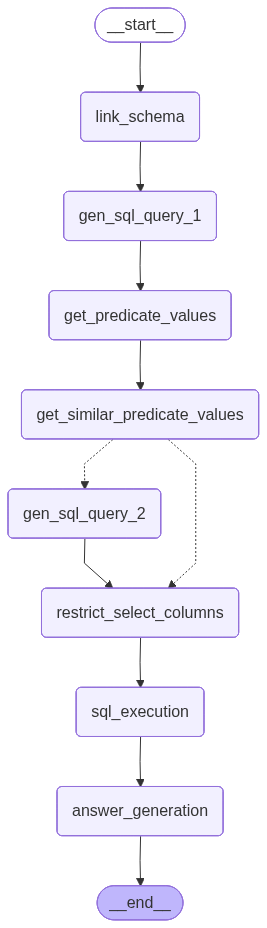

In [256]:
sql_assistant = build_sql_assistant_pipeline(llm, db)

display(Image(sql_assistant.get_graph().draw_mermaid_png()))

In [257]:
user_query = "tôi muốn thuê một căn 2 phòng ngủ, giá dưới 6tr 1 tháng"
state = await sql_assistant.ainvoke({"user_query": user_query})
print(state["final_answer"])

DEBUG: Found Aliases: {'BĐS Cho thuê 500': 'BĐS Cho thuê 500'}
DEBUG: Active Tables: {'BĐS Cho thuê 500': 'BĐS Cho thuê 500'}
Đã tìm thấy 1 căn hộ phù hợp với yêu cầu của bạn:

- **Địa chỉ**: 791 Đường A15, Quận 5  
- **Giá thuê**: 5.6 triệu đồng/tháng  
- **Số phòng ngủ**: 2 phòng


In [258]:
state

{'user_query': 'tôi muốn thuê một căn 2 phòng ngủ, giá dưới 6tr 1 tháng',
 'linked_schema': {'BĐS Bán 500': {'Số phòng ngủ': 'INTEGER',
   'Giá (tỷ VNĐ)': 'REAL',
   'Loại BĐS': 'TEXT',
   'Phường/Xã': 'TEXT',
   'Quận/Huyện': 'TEXT',
   'Tỉnh/TP': 'TEXT',
   'Tiện ích': 'TEXT'},
  'BĐS Cho thuê 500': {'Số phòng ngủ': 'INTEGER',
   'Giá thuê (triệu/tháng)': 'REAL',
   'Diện tích (m²)': 'INTEGER',
   'Quận/Huyện': 'TEXT',
   'Địa chỉ': 'TEXT'}},
 'sql_queries': ['SELECT "Địa chỉ", "Giá thuê (triệu/tháng)", "Số phòng ngủ" \nFROM "BĐS Cho thuê 500" \nWHERE "Số phòng ngủ" = 2 AND "Giá thuê (triệu/tháng)" < 6;',
  'SELECT "Địa chỉ", "Giá thuê (triệu/tháng)", "Số phòng ngủ" FROM "BĐS Cho thuê 500" WHERE "Số phòng ngủ" = 2 AND "Giá thuê (triệu/tháng)" < 6'],
 'predicate_values': [],
 'tbl_col_sample_values': {},
 'db_output': {'result': [{'Địa chỉ': '791 Đường A15, Quận 5',
    'Giá thuê (triệu/tháng)': 5.6,
    'Số phòng ngủ': 2}],
  'error': None},
 'final_answer': 'Đã tìm thấy 1 căn hộ phù

In [153]:
tmp = await db.run_no_throw("""
SELECT "BĐS Cho thuê 500"."Loại BĐS", "BĐS Cho thuê 500"."Địa chỉ", "BĐS Cho thuê 500"."Giá thuê (triệu/tháng)" FROM "BĐS Cho thuê 500"
""", include_columns=True)
tmp["result"][0]

{'Loại BĐS': 'Shophouse',
 'Địa chỉ': '69 Đường A1, Quận 3',
 'Giá thuê (triệu/tháng)': 34.2}

## Orchestrator

In [ ]:
ORCHESTRATOR_PROMPT = """
Bạn là một trợ lý ảo chuyên trả lời các câu hỏi về thị trường bất động sản dựa trên một bộ dữ liệu nội bộ. Cơ sở dữ liệu này bao gồm danh sách các bất động sản bán và cho thuê. Khi người dùng hỏi về các chủ đề này, nhiệm vụ của bạn là gọi một trợ lý ảo khác (SQL Assistant) và đưa ra mệnh lệnh (bằng ngôn ngữ tự nhiên) để trợ lý ảo thực hiện viết câu truy vấn, thu thập thông tin liên quan, và trả lời cho người dùng. Đối với các câu hỏi nằm ngoài lĩnh vực bất động sản này, hãy sử dụng kiến thức của bạn để trả lời trực tiếp.
""".strip()


class SQLAssistantInput(BaseModel):
    command: str = Field(description="Mệnh lệnh bằng Tiếng Việt")


@tool("call_sql_assistant",args_schema=SQLAssistantInput)
def call_sql_assistant(command: str) -> str:
    """Gọi trợ lý ảo SQL Assistant để thực hiện các câu truy vấn"""
    pass


orchestrator_chain = RunnablePassthrough.assign(
    messages=partial(
        preprocess_messages, system_prompt=ORCHESTRATOR_PROMPT)
    | get_llm_model().bind_tools([call_sql_assistant])
    | postprocess_ai_message
)

In [19]:
builder = StateGraph(MessagesState)
builder.add_node("orchestrator", orchestrator_chain)
builder.add_edge(START, "orchestrator")
builder.add_edge("orchestrator", END)

orchestrator = builder.compile()

In [62]:
start_time = time.time()
state = orchestrator.invoke({"messages": [
    # {"role": "user", "content": "hello"},
    # {"role": "user", "content": "Hello, hôm qua ngày bao nhiêu nhể"},
    # {"role": "assistant", "content": "Hôm qua là ngày 13 tháng 12 năm 2025"},
    # {"role": "user", "content": "Có bao nhiêu nhà đang được cho thuê nhỉ"}
    # {"role": "user", "content": "1 + 2 + 3 + ... + 100 = ?"}
    HumanMessage(content="Có bao nhiêu nhà đang được cho thuê nhỉ"),
    AIMessage(content="Tổng số nhà đang được cho thuê là 111 nhà."),
    HumanMessage(content="Cho tôi một vài căn duplex tôi muốn thuê"),
]})
for message in state["messages"]:
    print(message)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

content='Có bao nhiêu nhà đang được cho thuê nhỉ' additional_kwargs={} response_metadata={} id='35b88563-3f6e-4dce-b961-c5dd7efe44a2'
content='Tổng số nhà đang được cho thuê là 111 nhà.' additional_kwargs={} response_metadata={} id='f0634d64-f84b-45cc-8432-98f94f46626e'
content='Cho tôi một vài căn duplex tôi muốn thuê' additional_kwargs={} response_metadata={} id='950c27ac-5ef9-438a-b7e3-ff4db3af3004'
content='' additional_kwargs={} response_metadata={} id='b1aac9dc-51d5-481b-bd46-631419d38c46' tool_calls=[{'name': 'call_sql_assistant', 'args': {'command': 'Lấy thông tin về các căn duplex đang được cho thuê'}, 'id': '1', 'type': 'tool_call'}]
Time taken: 0.9143528938293457 seconds


In [103]:
state

{'query': 'Cho tôi một vài căn duplex tôi muốn thuê',
 'linked_schema': {'BĐS Bán 500': {'Loại BĐS': 'TEXT',
   'Diện tích (m²)': 'INTEGER',
   'Giá (tỷ VNĐ)': 'REAL',
   'Phường/Xã': 'TEXT',
   'Quận/Huyện': 'TEXT',
   'Địa chỉ': 'TEXT'},
  'BĐS Cho thuê 500': {'Loại BĐS': 'TEXT',
   'Diện tích (m²)': 'INTEGER',
   'Giá thuê (triệu/tháng)': 'REAL',
   'Địa chỉ': 'TEXT',
   'Quận/Huyện': 'TEXT',
   'Phường/Xã': 'TEXT'}},
 'sql_query_1': 'SELECT * FROM "BĐS Cho thuê 500" \nWHERE "Loại BĐS" = \'Duplex\';',
 'db_output_1': {'result': [], 'error': None},
 'predicate_values': [{'table_name': 'BĐS Cho thuê 500',
   'column_name': 'Loại BĐS',
   'value': 'Duplex',
   'operator': 'eq'}],
 'tbl_col_sample_values': {'BĐS Cho thuê 500': {'Loại BĐS': ['Biệt thự',
    'Phòng trọ',
    'Căn hộ chung cư',
    'Studio',
    'Nhà xưởng']}},
 'sql_query_2': 'SELECT * FROM "BĐS Cho thuê 500" \nWHERE "Loại BĐS" = \'Duplex\';',
 'db_output_2': {'result': [], 'error': None},
 'final_answer': 'Không tìm thấy

# Generate description

In [ ]:
chat_reasoning_model = get_thinking_llm_model()

In [115]:
TABLE_DESCRIPTION_PROMPT = """
Bạn là một chuyên gia quản trị dữ liệu (Data Steward). Nhiệm vụ của bạn là phân tích cấu trúc và dữ liệu mẫu của một bảng (table) để tạo ra mô tả tóm tắt (metadata).

Mô tả này sẽ được sử dụng bởi một AI Router để quyết định xem câu hỏi của người dùng có liên quan đến bảng này hay không.

HÃY PHÂN TÍCH DỰA TRÊN SCHEMA CỦA BẢNG:
{table_info}

YÊU CẦU ĐẦU RA (Định dạng JSON):
Hãy trả về một JSON object duy nhất đặt trong ```json ...``` với các trường sau:
- "human_name": Tên ngắn gọn, dễ hiểu cho người dùng.
- "summary": Phần mô tả bảng bằng tiếng Việt. Nêu rõ bảng này chứa thông tin về **đối tượng gì** (Entity) và **thuộc tính quan trọng nào**.
""".strip()

table_names = db.get_usable_table_names()
table_info = db.get_table_info_no_throw(
    table_name=table_names[1],
    get_col_comments=True,
    sample_count=5,
)

In [116]:
tmp = chat_reasoning_model.invoke(TABLE_DESCRIPTION_PROMPT.format(table_info=table_info))
print(tmp.content)

<think>
Okay, let's tackle this. The user wants me to act as a Data Steward and create a metadata summary for the "BĐS Cho thuê 500" table. The goal is to help an AI Router determine if user questions relate to this table.

First, I need to understand the schema. Let me go through each column. The table name translates to "Real Estate for Rent 500," so it's about rental properties. The columns include details like security, balcony, parking, kitchen, pet policy, area, project name, contact info, notes, price, location, etc.

I should identify the main entity here. It's clearly real estate properties available for rent. Now, the important attributes. Let me list them out: security features, outdoor spaces, parking options, kitchen facilities, pet policies, area in square meters, project names, contact details, notes, rental prices, price per square meter, location details (district, ward, province), dates for move-in, number of bedrooms and bathrooms, floor numbers, elevator availabilit